# Classification

In [2]:
#loading required d libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
import lightgbm as lgb
from sklearn.metrics import roc_auc_score,accuracy_score,classification_report,confusion_matrix,roc_curve
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
import pickle
from lightgbm import LGBMClassifier, plot_importance
from xgboost import plot_importance as plot_xg
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#helper function
def report(y_true,y_preds):
    print(classification_report(y_true,y_preds))
    print("*"*10+"Confusion Matrix"+"*"*10+'\n',confusion_matrix(y_true,y_preds))
    print("AUC_ROC:",roc_auc_score(y_true,y_preds))
    print("accuracy:",accuracy_score(y_true,y_preds))

### Data loading and processing for models

In [4]:
#load_data
mean_imputed = pd.read_csv('mean_zero_imputed.csv')
X = mean_imputed.drop(['cuid','convert_30','revenue_30'],axis=1)
y = mean_imputed.convert_30

**Labelencoder to encode the categorical features**

In [5]:
#Label encoding categorical features
cat_cols = X.select_dtypes(include='object').columns
cat_indices = []
for col in cat_cols:
    cat_indices.append(X.columns.get_loc(col))
    

    
#Label encoding cat columns
X_labeled = X
X_labeled[cat_cols] = X[cat_cols].apply(LabelEncoder().fit_transform)

**Splitting the data into train and test sets**

In [6]:
X_train,X_test,y_train,y_test = train_test_split(X_labeled,y,
                                                 stratify=y,test_size=0.33,random_state=1)


**Dropping columns**
Dropping the columns which are highly correlated to eachother (threshold>0.9)

In [7]:
to_drop = ['dayssincelastord',
 'cuidshare',
 'numstores',
 'avgnps',
 'maxnps',
 'numvisittotal',
 'numskusviewedone',
 'numskusviewedthreeone',
 'numskusviewedseventhree',
 'numskusviewedthirtyseven',
 'numskusviewedsixtythirty',
 'numskusviewedyearsixty']

## LightGBM classifier

In [17]:
print('*'*50)
print('*'*16+"Best LightGBM model"+'*'*15)
filename = 'lgbm_corr_auc0.725acc0.767.pkl'
lgbmc_model = pickle.load(open(filename, 'rb'))
preds_lgbm_proba = lgbmc_model.predict_proba(X_test.drop(to_drop,axis=1))
preds_lgbm = np.where(preds_lgbm_proba[:,1]>0.5,1,0)

report(y_test,preds_lgbm)

print(lgbmc_model.get_params)

**************************************************
****************Best LightGBM model***************
              precision    recall  f1-score   support

           0       0.95      0.78      0.86      8316
           1       0.26      0.67      0.38       966

    accuracy                           0.77      9282
   macro avg       0.61      0.73      0.62      9282
weighted avg       0.88      0.77      0.81      9282

**********Confusion Matrix**********
 [[6475 1841]
 [ 317  649]]
AUC_ROC: 0.7252310893615241
accuracy: 0.7675070028011205
<bound method LGBMModel.get_params of LGBMClassifier(boosting_type='goss', class_weight='balanced',
               colsample_bytree=0.5614765813252803, importance_type='split',
               learning_rate=0.1, max_depth=-1, metric=None,
               min_child_samples=105, min_child_weight=0.01, min_split_gain=0.0,
               n_estimators=5000, n_jobs=4, num_leaves=40, objective=None,
               random_state=314, reg_alpha=10, reg_lamb

### Feature importance of LightGBM classifier

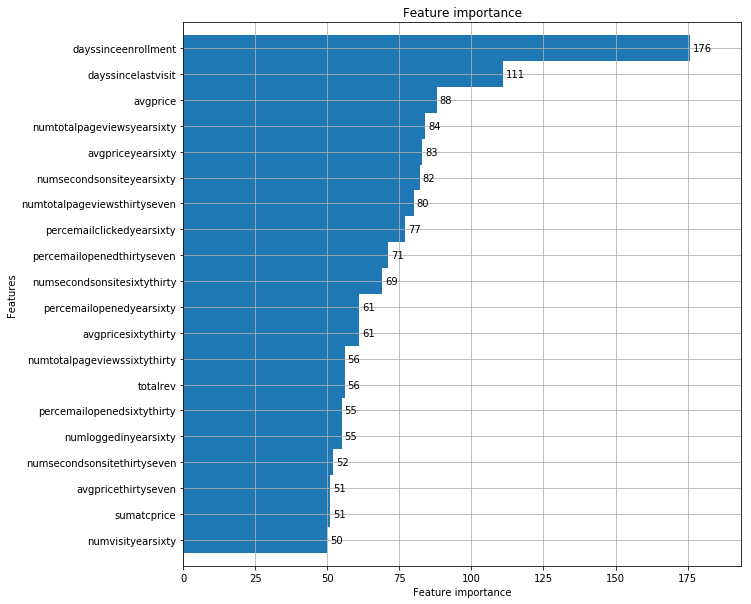

In [9]:
figsize=(10,10)
fig, ax = plt.subplots(1,1,figsize=figsize)
plot_importance(lgbmc_model,max_num_features=20,ax=ax,height=1)

## XGBOOST classification

In [10]:
filename = 'xg_corr_auc0.723acc0.765.pkl'
loaded_xgbc = pickle.load(open(filename, 'rb'))
preds_xg_proba = loaded_xgbc.predict_proba(X_test.drop(to_drop,axis=1))
preds_xg = np.where(preds_xg_proba[:,:1]>0.5,0,1)
report(y_test,preds_xg)

              precision    recall  f1-score   support

           0       0.95      0.78      0.86      8316
           1       0.26      0.67      0.37       966

    accuracy                           0.77      9282
   macro avg       0.61      0.72      0.61      9282
weighted avg       0.88      0.77      0.81      9282

**********Confusion Matrix**********
 [[6462 1854]
 [ 318  648]]
AUC_ROC: 0.723931865236213
accuracy: 0.7659987071751778


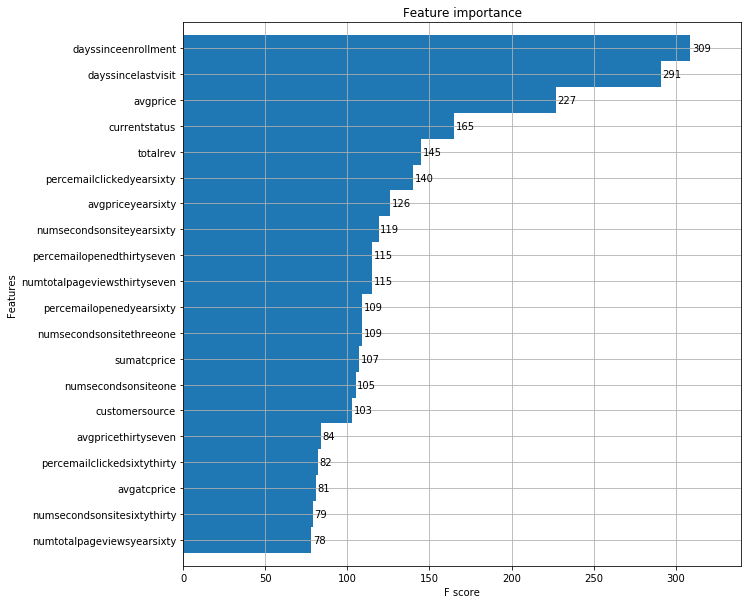

In [11]:
figsize=(10,10)
fig, ax = plt.subplots(1,1,figsize=figsize)
plot_xg(loaded_xgbc,max_num_features=20,ax=ax,height=1)

## Averaging

**Simple averaging**

In [12]:
#Simple averaging
preds3_proba = ((preds_lgbm_proba*0.5+preds_xg_proba*0.5)[:,:1])

preds3 = np.where(preds3_proba>0.5,0,1)
report(y_test,preds3)

              precision    recall  f1-score   support

           0       0.95      0.78      0.86      8316
           1       0.27      0.68      0.38       966

    accuracy                           0.77      9282
   macro avg       0.61      0.73      0.62      9282
weighted avg       0.88      0.77      0.81      9282

**********Confusion Matrix**********
 [[6498 1818]
 [ 309  657]]
AUC_ROC: 0.730754752493883
accuracy: 0.770846800258565


**Weighted averaging**

In [13]:
### Combining both lightgbm and xgboost classifiers

preds3_proba = ((preds_lgbm_proba*0.63+preds_xg_proba*0.37)[:,:1])

preds3 = np.where(preds3_proba>0.5,0,1)
report(y_test,preds3)

              precision    recall  f1-score   support

           0       0.96      0.78      0.86      8316
           1       0.27      0.68      0.38       966

    accuracy                           0.77      9282
   macro avg       0.61      0.73      0.62      9282
weighted avg       0.88      0.77      0.81      9282

**********Confusion Matrix**********
 [[6511 1805]
 [ 306  660]]
AUC_ROC: 0.7330891733065646
accuracy: 0.7725705666882138


### Summary
* Both LGBM and XGBOOST performed well.
* One is good on AUC and the other on Accuracy.
* Here's a summary of results

|Model|Accuracy|AUC_ROC|
|-----|--------|-------|
|LightGBM|0.7675|0.7252|
|XGBoost|0.7659|0.7239|
|Simple avg|0.7708|0.7307|
|Weighted avg|0.7725|0.7330|